In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install mne
from tensorflow.keras.layers import CategoryEncoding
from keras.layers import Lambda, Input, Dense, LeakyReLU, Flatten, Reshape, GlobalAveragePooling2D, BatchNormalization
from keras.layers.convolutional import Conv2D,Conv2DTranspose, MaxPooling2D
from keras.layers.core import Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

import sklearn.multioutput as MOR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import welch
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from mne.decoding import Vectorizer

import mne
from mne.preprocessing import ICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import argparse
import os
import h5py
import scipy.io as sio
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 5.5 MB/s 


In [ ]:
batch_size = 5
channel_dim = 14
latent_dim=15
epoch_dim=95
epochs = 50
subNum = 32
zscore = True
sample_dim=512

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# PSEUDO CLASSIFIER
def pseudo(X,y,estimator):
  "Classifier that is used to generate pseudo-labels for observations in data that are unlabelled"
  # INDICES
  unlabelled_indices=np.where(y==0)
  labelled_indices=np.where(y!=0)

  # LABELLED/UNLABELLED DATA WITH TARGETS
  X_labelled=X[labelled_indices]
  y_labelled=y[labelled_indices]

  X_unlabelled=X[unlabelled_indices]

  # PREDICTIONS FOR PSEUDO-LABELS
  regr_labelled=estimator.fit(X_labelled,y_labelled)
  pred_labelled=regr_labelled.predict(X_unlabelled)

  y[unlabelled_indices]=pred_labelled

  return y

In [ ]:
# Import files from mydata
X_data=np.zeros([9,95,14,512])
y_data=np.zeros([9,95,3])

for participant in range(9):
  path='/content/drive/My Drive/Dissertation/MYDATA_NEW/s0'+str(participant+1)+'/'
  X=pd.read_csv(path+'data_s0'+str(participant+1)+'.csv')
  X=X.iloc[:,1:]
  X=X.to_numpy()
  for epoch in range(95):
    X_data[participant][epoch]=np.transpose(X[512*epoch:512*(epoch+1)])

  y=pd.read_csv(path+'labels_s0'+str(participant+1)+'.csv')
  y=y.iloc[:,1:]
  y=y.to_numpy()
  y_data[participant]=y

path_00='/content/drive/My Drive/Dissertation/MYDATA_NEW/s00/'

X_00_data=np.zeros([94,14,512])
X_00=pd.read_csv(path_00+'data_s00.csv')
X_00=X_00.iloc[:,1:]
X_00=X_00.to_numpy()
for epoch in range(94):
  X_00_data[epoch]=np.transpose(X_00[512*epoch:512*(epoch+1)])

y_00=pd.read_csv(path_00+'labels_s00.csv')
y_00=y_00.iloc[:,1:]
y_00=y_00.to_numpy()


X_data.shape


(9, 95, 14, 512)

In [ ]:
# data normalization
for participant in range(X_data.shape[0]):
  mu=np.mean(X_data[participant],axis=0)
  std=np.std(X_data[participant],axis=0,ddof=1)
  for epoch in range(X_data.shape[1]):
    X_data[participant][epoch]=(X_data[participant][epoch]-mu)/std

mu_00=np.mean(X_00_data[participant],axis=0)
std_00=np.std(X_00_data[participant],axis=0,ddof=1)
for epoch in range(X_00_data.shape[0]):
  X_00_data[epoch]=(X_00_data[epoch]-mu_00)/std_00

In [ ]:
# FILTERING AND ICA
# BANDPASS FILTER
channels=['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
info=mne.create_info(ch_names=channels,sfreq=128,ch_types='eeg')

for participant in range(X_data.shape[0]):
  for epoch in range(X_data.shape[0]):
    raw=mne.io.RawArray(X_data[participant][epoch],info)
    eeg_channels = mne.pick_types(raw.info, eeg=True,emg=True,ecg=True,eog=True)
    cov=mne.compute_raw_covariance(raw, picks=eeg_channels)
    raw.del_proj()
    filt_raw = raw.copy().filter(l_freq=4, h_freq=50,picks=eeg_channels)

    # ICA
    ica = ICA(n_components=14,noise_cov=cov,method='fastica',max_iter='auto',random_state=97)
    ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
    ica.exclude = [2]
    reconst_raw = filt_raw.copy()
    ica.apply(reconst_raw)

    X_data[participant][epoch]=reconst_raw.get_data()

for epoch in range(X_00_data.shape[0]):
  raw_00=mne.io.RawArray(X_00_data[epoch],info)
  eeg_channels_00 = mne.pick_types(raw_00.info, eeg=True,emg=True,ecg=True,eog=True)
  cov_00=mne.compute_raw_covariance(raw_00, picks=eeg_channels_00)
  raw_00.del_proj()
  filt_raw_00 = raw_00.copy().filter(l_freq=4, h_freq=50,picks=eeg_channels_00)

  ica_00 = ICA(n_components=14,noise_cov=cov_00,method='fastica',max_iter='auto',random_state=97)
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
  ica_00.exclude = [2]
  reconst_raw_00 = filt_raw_00.copy()
  ica_00.apply(reconst_raw)

  X_00_data[epoch]=reconst_raw_00.get_data()

print(X_data.shape)
print(X_00_data.shape)

Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 3.9e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 14 dim * 1.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 14 dim * 1.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim *

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 4.2e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 14 dim * 1.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments


<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covar

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 4.2e-05 (2.2e-16 eps * 14 dim * 1.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)


<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim *

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 14 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 3.9e-05 (2.2e-16 eps * 14 dim * 1.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 14 dim * 2.5e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise cov

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.6e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (0.93) and smallest (8e-32) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 8e-05 (2.2e-16 eps * 14 dim * 2.6e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff freque

<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 6.3e-05 (2.2e-16 eps * 14 dim * 2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff freque

<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.5e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.6e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.6e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 5.9e-05 (2.2e-16 eps * 14 dim * 1.9e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (plea

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 3.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.8e-05 (2.2e-16 eps * 14 dim * 2.5e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 4.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 6.4e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.5e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 8e-05 (2.2e-16 eps * 14 dim * 2.6e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.1e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff freque

<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.5e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.6e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 14 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 7.4e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff freque

<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 14 dim * 2.2e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 14 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Using tolerance 6.6e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 6.6e-05 (2.2e-16 eps * 14 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-43-9ab838d8f9fc>:31: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica_00.fit(filt_raw_00,picks=eeg_channels_00,reject_by_annotation=True)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
(9, 95, 14, 512)
(94, 14, 512)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [ ]:
X_data_reshaped=np.zeros([9,95,512,14,1])
X_data_reshaped_00=np.zeros([94,512,14,1])
for participant in range(X_data.shape[0]):
  x_train=tf.expand_dims(X_data[participant],3)

  lst=[]
  for epoch in range(X_data.shape[1]):
    lst.append(tf.transpose(x_train[epoch,:,:,0]))
  x_train=tf.stack(lst)
  x_train=tf.expand_dims(x_train,3)
  X_data_reshaped[participant]=x_train
x_test=X_data_reshaped

x_train_00=tf.expand_dims(X_00_data,3)
lst_00=[]
for epoch in range(X_00_data.shape[0]):
  lst_00.append(tf.transpose(x_train_00[epoch,:,:,0]))
x_train_00=tf.stack(lst_00)
x_train_00=tf.expand_dims(x_train_00,3)
X_data_reshaped_00=x_train_00
x_test_00=X_data_reshaped_00
print(X_data_reshaped.shape)
print(X_data_reshaped_00.shape)

(9, 95, 512, 14, 1)
(94, 512, 14, 1)


In [ ]:
X_pred=np.zeros([9,95,100])
X_pred_00=np.zeros([94,100])

# Encoder
for participant in range(9):
  inputs=Input(shape=(sample_dim,channel_dim,1),name='encoder_input')
  h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs)
  h=BatchNormalization(axis=-1)(h)
  h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
  h=BatchNormalization(axis=-1)(h)
  h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
  h=BatchNormalization(axis=-1)(h)
  h=Dropout(0.5)(h)
  h=Flatten()(h)
  h = Dense(270,activation=LeakyReLU(alpha=0.3))(h)
  z_mean = Dense(100, name='z_mean')(h)
  z_log_var = Dense(100, name='z_log_var')(h)
  z = Lambda(sampling, output_shape=(100,), name='z')([z_mean, z_log_var])
  encoder= Model(inputs, [z_mean, z_log_var, z], name='encoder')
  # encoder.summary()
  # plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

  # Decoder
  latent_inputs = Input(shape=(100,), name='z_sampling')
  h_decoded = Dense(270,activation=LeakyReLU(alpha=0.3))(latent_inputs)
  h_decoded = Dense(540,activation=LeakyReLU(alpha=0.3))(h_decoded)
  inputs_decoded=Reshape((18,1,30))(h_decoded)
  inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Dropout(0.5)(inputs_decoded)
  inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Conv2DTranspose(1,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,0),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Reshape((sample_dim,channel_dim,1))(inputs_decoded)
  decoder = Model(latent_inputs, inputs_decoded, name='decoder')
  # decoder.summary()
  # plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

  #VAE
  outputs = decoder(encoder.output[2])
  vae = Model(inputs, outputs, name='vae_mlp')
  # vae.summary()
  # plot_model(vae,to_file='vae_mlp.png', show_shapes=True)

  # Loss function
  reconstruction_loss=K.square(inputs)-K.square(outputs)
  reconstruction_loss = K.mean(reconstruction_loss, axis=None)
  reconstruction_loss *= channel_dim

  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)

  vae.add_loss(vae_loss)
  rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
  vae.compile(optimizer=rmsprop)


  callback=ModelCheckpoint(filepath='/content/drive/My Drive/Dissertation/DEAP/checkpoints/',
                            save_weights_only=True,
                            save_best_only=True)
                            

  # train the autoencoder
  history=vae.fit(X_data_reshaped[participant],
                  epochs=epochs,
                  steps_per_epoch=40//batch_size,
                  batch_size=batch_size,
                  validation_data=(x_test[participant],None),
                  validation_steps=40//batch_size)

  # save the model
  vae.save_weights('/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/vae_mydata_'+str(participant+1)+'.h5',overwrite=True,save_format='h5')
  encoder.save_weights('/content/drive/My Drive/Dissertation/DEAP/checkpoints/encoder_mydata_'+str(participant+1)+'.h5',overwrite=True,save_format='h5')

  X_pred[participant]=encoder.predict(X_data_reshaped[participant])[2]

  vae.load_weights('/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/vae_mydata_'+str(participant+1)+'.h5')

  plt.clf()

  fig = go.Figure()
  fig.add_trace(go.Scattergl(
                      y=history.history['loss'],
                      name='Train'))
  fig.add_trace(go.Scattergl(
                      y=history.history['val_loss'],
                      name='Valid'))
  fig.update_layout(height=500, 
                    width=700,
                    title='Loss function',
                    xaxis_title='Epoch',
                    yaxis_title='Loss')
  fig.show()



# FIRST PARTICIPANT ONLY
# Encoder
inputs=Input(shape=(sample_dim,channel_dim,1),name='encoder_input')
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Dropout(0.5)(h)
h=Flatten()(h)
h = Dense(270,activation=LeakyReLU(alpha=0.3))(h)
z_mean = Dense(100, name='z_mean')(h)
z_log_var = Dense(100, name='z_log_var')(h)
z = Lambda(sampling, output_shape=(100,), name='z')([z_mean, z_log_var])
encoder= Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# Decoder
latent_inputs = Input(shape=(100,), name='z_sampling')
h_decoded = Dense(270,activation=LeakyReLU(alpha=0.3))(latent_inputs)
h_decoded = Dense(540,activation=LeakyReLU(alpha=0.3))(h_decoded)
inputs_decoded=Reshape((18,1,30))(h_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Dropout(0.5)(inputs_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Conv2DTranspose(1,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,0),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Reshape((sample_dim,channel_dim,1))(inputs_decoded)
decoder = Model(latent_inputs, inputs_decoded, name='decoder')
# decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

#VAE
outputs = decoder(encoder.output[2])
vae = Model(inputs, outputs, name='vae_mlp')
# vae.summary()
# plot_model(vae,to_file='vae_mlp.png', show_shapes=True)


# Loss function
reconstruction_loss=K.square(inputs)-K.square(outputs)
reconstruction_loss = K.mean(reconstruction_loss, axis=None)
reconstruction_loss *= channel_dim


kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=rmsprop)


callback=ModelCheckpoint(filepath='/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/',
                          save_weights_only=True,
                          save_best_only=True)
                          

# train the autoencoder
history=vae.fit(X_data_reshaped_00,
                epochs=epochs,
                steps_per_epoch=40//batch_size,
                batch_size=batch_size,
                validation_data=(x_test_00,None),
                validation_steps=40//batch_size)

# save the model
vae.save_weights('/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/vae_mydata_0.h5',overwrite=True,save_format='h5')
encoder.save_weights('/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/encoder_mydata_0.h5',overwrite=True,save_format='h5')

X_pred_00=encoder.predict(X_data_reshaped_00)[2]

vae.load_weights('/content/drive/My Drive/Dissertation/MYDATA_NEW/checkpoints/vae_mydata_0.h5')

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Loss function',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

Epoch 1/50
8/8 [==============================] - 4s 99ms/step - loss: 191.5483 - val_loss: 13.7353
Epoch 2/50
8/8 [==============================] - 0s 55ms/step - loss: 180.1665 - val_loss: 13.7684
Epoch 3/50
8/8 [==============================] - 0s 55ms/step - loss: 167.1089 - val_loss: 13.8701
Epoch 4/50
8/8 [==============================] - 0s 55ms/step - loss: 174.3569 - val_loss: 14.0122
Epoch 5/50
8/8 [==============================] - 0s 44ms/step - loss: 164.0317 - val_loss: 14.1934
Epoch 6/50
8/8 [==============================] - 0s 49ms/step - loss: 170.2497 - val_loss: 14.4036
Epoch 7/50
8/8 [==============================] - 0s 53ms/step - loss: 154.4212 - val_loss: 14.6357
Epoch 8/50
8/8 [==============================] - 0s 49ms/step - loss: 141.3848 - val_loss: 14.8789
Epoch 9/50
8/8 [==============================] - 0s 57ms/step - loss: 141.7509 - val_loss: 15.1439
Epoch 10/50
8/8 [==============================] - 0s 55ms/step - loss: 141.1070 - val_loss: 15.4211

Epoch 1/50
8/8 [==============================] - 3s 95ms/step - loss: 196.5216 - val_loss: 13.6875
Epoch 2/50
8/8 [==============================] - 0s 50ms/step - loss: 195.4915 - val_loss: 13.7178
Epoch 3/50
8/8 [==============================] - 0s 47ms/step - loss: 189.6761 - val_loss: 13.8211
Epoch 4/50
8/8 [==============================] - 0s 50ms/step - loss: 168.3886 - val_loss: 14.0026
Epoch 5/50
8/8 [==============================] - 0s 49ms/step - loss: 150.5918 - val_loss: 14.2401
Epoch 6/50
8/8 [==============================] - 0s 55ms/step - loss: 157.6210 - val_loss: 14.5134
Epoch 7/50
8/8 [==============================] - 0s 46ms/step - loss: 164.0702 - val_loss: 14.8343
Epoch 8/50
8/8 [==============================] - 0s 49ms/step - loss: 150.0266 - val_loss: 15.1846
Epoch 9/50
8/8 [==============================] - 0s 47ms/step - loss: 153.4147 - val_loss: 15.5589
Epoch 10/50
8/8 [==============================] - 0s 48ms/step - loss: 141.6573 - val_loss: 15.9511

Epoch 1/50
8/8 [==============================] - 4s 125ms/step - loss: 206.8630 - val_loss: 13.7913
Epoch 2/50
8/8 [==============================] - 0s 59ms/step - loss: 196.6530 - val_loss: 13.7633
Epoch 3/50
8/8 [==============================] - 0s 50ms/step - loss: 173.1300 - val_loss: 13.8193
Epoch 4/50
8/8 [==============================] - 0s 55ms/step - loss: 179.7189 - val_loss: 13.9311
Epoch 5/50
8/8 [==============================] - 0s 55ms/step - loss: 170.9753 - val_loss: 14.0792
Epoch 6/50
8/8 [==============================] - 0s 53ms/step - loss: 165.9608 - val_loss: 14.2683
Epoch 7/50
8/8 [==============================] - 0s 57ms/step - loss: 172.9701 - val_loss: 14.4786
Epoch 8/50
8/8 [==============================] - 1s 65ms/step - loss: 163.6501 - val_loss: 14.7016
Epoch 9/50
8/8 [==============================] - 0s 50ms/step - loss: 147.2680 - val_loss: 14.9643
Epoch 10/50
8/8 [==============================] - 0s 54ms/step - loss: 154.8874 - val_loss: 15.202

Epoch 1/50
8/8 [==============================] - 3s 103ms/step - loss: 198.9754 - val_loss: 13.7267
Epoch 2/50
8/8 [==============================] - 0s 51ms/step - loss: 199.9309 - val_loss: 13.7260
Epoch 3/50
8/8 [==============================] - 0s 53ms/step - loss: 184.3004 - val_loss: 13.8031
Epoch 4/50
8/8 [==============================] - 0s 54ms/step - loss: 178.5363 - val_loss: 13.9406
Epoch 5/50
8/8 [==============================] - 0s 51ms/step - loss: 166.7775 - val_loss: 14.1115
Epoch 6/50
8/8 [==============================] - 0s 62ms/step - loss: 162.3441 - val_loss: 14.3240
Epoch 7/50
8/8 [==============================] - 0s 57ms/step - loss: 160.8268 - val_loss: 14.5583
Epoch 8/50
8/8 [==============================] - 0s 59ms/step - loss: 168.8782 - val_loss: 14.8161
Epoch 9/50
8/8 [==============================] - 0s 53ms/step - loss: 147.6841 - val_loss: 15.1025
Epoch 10/50
8/8 [==============================] - 0s 51ms/step - loss: 148.1030 - val_loss: 15.394

Epoch 1/50
8/8 [==============================] - 5s 101ms/step - loss: 211.7845 - val_loss: 13.7913
Epoch 2/50
8/8 [==============================] - 0s 48ms/step - loss: 194.2420 - val_loss: 13.7994
Epoch 3/50
8/8 [==============================] - 0s 49ms/step - loss: 170.1396 - val_loss: 13.9123
Epoch 4/50
8/8 [==============================] - 0s 52ms/step - loss: 179.9024 - val_loss: 14.1025
Epoch 5/50
8/8 [==============================] - 0s 48ms/step - loss: 175.4828 - val_loss: 14.3498
Epoch 6/50
8/8 [==============================] - 0s 50ms/step - loss: 169.6423 - val_loss: 14.6571
Epoch 7/50
8/8 [==============================] - 0s 47ms/step - loss: 160.8596 - val_loss: 14.9959
Epoch 8/50
8/8 [==============================] - 0s 46ms/step - loss: 161.2193 - val_loss: 15.3521
Epoch 9/50
8/8 [==============================] - 0s 51ms/step - loss: 152.7834 - val_loss: 15.7396
Epoch 10/50
8/8 [==============================] - 0s 57ms/step - loss: 150.2275 - val_loss: 16.103

Epoch 1/50
8/8 [==============================] - 3s 95ms/step - loss: 222.6437 - val_loss: 13.9068
Epoch 2/50
8/8 [==============================] - 0s 47ms/step - loss: 197.8952 - val_loss: 13.8360
Epoch 3/50
8/8 [==============================] - 0s 49ms/step - loss: 177.7903 - val_loss: 13.8577
Epoch 4/50
8/8 [==============================] - 0s 53ms/step - loss: 177.5402 - val_loss: 13.9679
Epoch 5/50
8/8 [==============================] - 0s 52ms/step - loss: 197.3517 - val_loss: 14.1388
Epoch 6/50
8/8 [==============================] - 0s 49ms/step - loss: 160.2202 - val_loss: 14.3503
Epoch 7/50
8/8 [==============================] - 0s 47ms/step - loss: 166.3253 - val_loss: 14.6025
Epoch 8/50
8/8 [==============================] - 0s 48ms/step - loss: 148.3689 - val_loss: 14.8835
Epoch 9/50
8/8 [==============================] - 0s 46ms/step - loss: 151.5980 - val_loss: 15.1644
Epoch 10/50
8/8 [==============================] - 0s 46ms/step - loss: 155.0516 - val_loss: 15.4833

Epoch 1/50
8/8 [==============================] - 3s 93ms/step - loss: 196.0518 - val_loss: 13.8788
Epoch 2/50
8/8 [==============================] - 0s 46ms/step - loss: 211.2477 - val_loss: 13.8206
Epoch 3/50
8/8 [==============================] - 0s 52ms/step - loss: 180.3613 - val_loss: 13.8656
Epoch 4/50
8/8 [==============================] - 0s 49ms/step - loss: 180.1381 - val_loss: 13.9931
Epoch 5/50
8/8 [==============================] - 0s 55ms/step - loss: 188.9405 - val_loss: 14.1802
Epoch 6/50
8/8 [==============================] - 0s 61ms/step - loss: 166.1316 - val_loss: 14.4343
Epoch 7/50
8/8 [==============================] - 0s 48ms/step - loss: 174.1111 - val_loss: 14.7062
Epoch 8/50
8/8 [==============================] - 0s 51ms/step - loss: 161.7541 - val_loss: 15.0044
Epoch 9/50
8/8 [==============================] - 0s 49ms/step - loss: 158.5976 - val_loss: 15.3388
Epoch 10/50
8/8 [==============================] - 0s 48ms/step - loss: 155.4721 - val_loss: 15.6986

Epoch 1/50
8/8 [==============================] - 3s 104ms/step - loss: 198.6797 - val_loss: 13.7327
Epoch 2/50
8/8 [==============================] - 1s 71ms/step - loss: 176.2074 - val_loss: 13.7305
Epoch 3/50
8/8 [==============================] - 0s 56ms/step - loss: 163.9671 - val_loss: 13.8365
Epoch 4/50
8/8 [==============================] - 0s 51ms/step - loss: 173.1440 - val_loss: 13.9997
Epoch 5/50
8/8 [==============================] - 0s 50ms/step - loss: 164.1532 - val_loss: 14.2258
Epoch 6/50
8/8 [==============================] - 0s 52ms/step - loss: 161.7235 - val_loss: 14.4808
Epoch 7/50
8/8 [==============================] - 0s 46ms/step - loss: 153.3121 - val_loss: 14.7689
Epoch 8/50
8/8 [==============================] - 0s 48ms/step - loss: 146.4080 - val_loss: 15.0945
Epoch 9/50
8/8 [==============================] - 0s 46ms/step - loss: 136.9442 - val_loss: 15.4134
Epoch 10/50
8/8 [==============================] - 0s 46ms/step - loss: 138.5062 - val_loss: 15.738

Epoch 1/50
8/8 [==============================] - 4s 97ms/step - loss: 179.7201 - val_loss: 13.8386
Epoch 2/50
8/8 [==============================] - 0s 46ms/step - loss: 168.9137 - val_loss: 13.8425
Epoch 3/50
8/8 [==============================] - 0s 48ms/step - loss: 162.5671 - val_loss: 13.9197
Epoch 4/50
8/8 [==============================] - 0s 48ms/step - loss: 163.2959 - val_loss: 14.0324
Epoch 5/50
8/8 [==============================] - 0s 48ms/step - loss: 175.8194 - val_loss: 14.1800
Epoch 6/50
8/8 [==============================] - 0s 56ms/step - loss: 162.7423 - val_loss: 14.3529
Epoch 7/50
8/8 [==============================] - 0s 52ms/step - loss: 152.7228 - val_loss: 14.5584
Epoch 8/50
8/8 [==============================] - 0s 51ms/step - loss: 152.9332 - val_loss: 14.7825
Epoch 9/50
8/8 [==============================] - 0s 51ms/step - loss: 148.8165 - val_loss: 15.0224
Epoch 10/50
8/8 [==============================] - 0s 53ms/step - loss: 142.2732 - val_loss: 15.2620

Epoch 1/50
8/8 [==============================] - 3s 104ms/step - loss: 185.6093 - val_loss: 14.0075
Epoch 2/50
8/8 [==============================] - 0s 51ms/step - loss: 167.5767 - val_loss: 13.9273
Epoch 3/50
8/8 [==============================] - 0s 51ms/step - loss: 163.4077 - val_loss: 13.9691
Epoch 4/50
8/8 [==============================] - 0s 48ms/step - loss: 150.8796 - val_loss: 14.1068
Epoch 5/50
8/8 [==============================] - 0s 50ms/step - loss: 149.2112 - val_loss: 14.3242
Epoch 6/50
8/8 [==============================] - 0s 50ms/step - loss: 138.3375 - val_loss: 14.5971
Epoch 7/50
8/8 [==============================] - 0s 52ms/step - loss: 132.4725 - val_loss: 14.8945
Epoch 8/50
8/8 [==============================] - 0s 55ms/step - loss: 129.9986 - val_loss: 15.2394
Epoch 9/50
8/8 [==============================] - 0s 62ms/step - loss: 128.8265 - val_loss: 15.5903
Epoch 10/50
8/8 [==============================] - 0s 56ms/step - loss: 125.3898 - val_loss: 15.973

<Figure size 432x288 with 0 Axes>

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512, 14, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 170, 7, 30)   210         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 170, 7, 30)  120         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

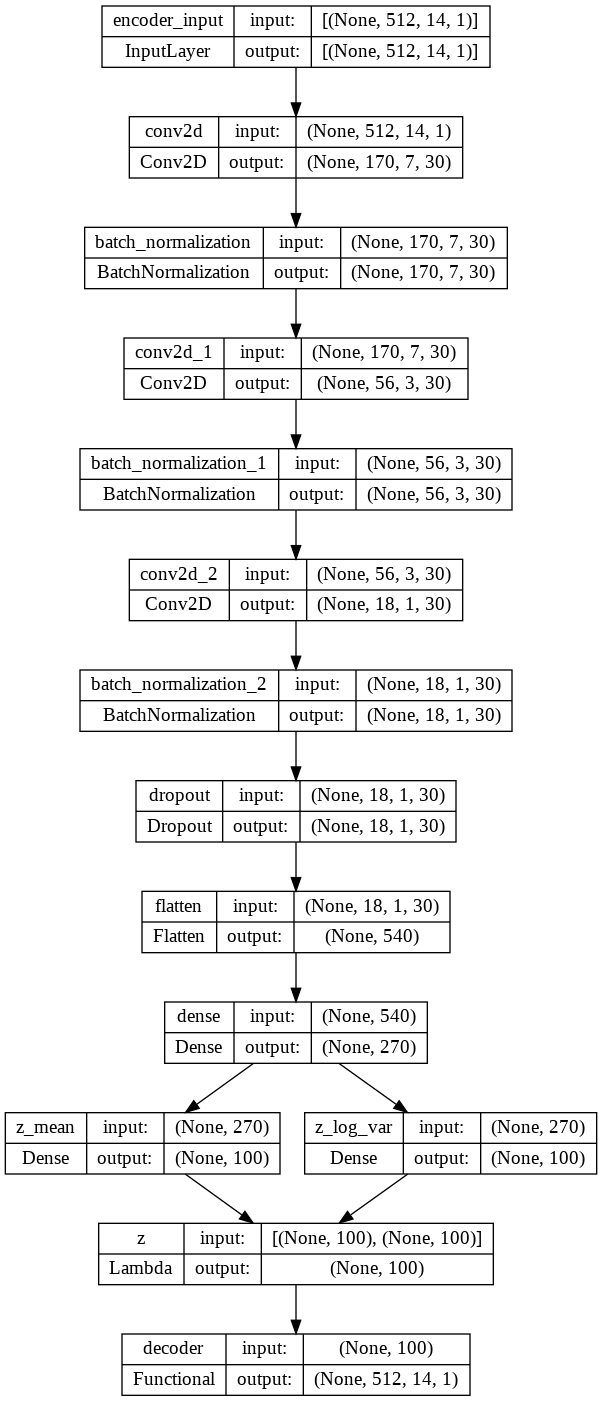

In [ ]:
# VISUALIZING THE ARCHITECTURE
# Encoder
inputs=Input(shape=(sample_dim,channel_dim,1),name='encoder_input')
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(3,2),strides=(3,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Dropout(0.5)(h)
h=Flatten()(h)
h = Dense(270,activation=LeakyReLU(alpha=0.3))(h)
z_mean = Dense(100, name='z_mean')(h)
z_log_var = Dense(100, name='z_log_var')(h)
z = Lambda(sampling, output_shape=(100,), name='z')([z_mean, z_log_var])
encoder= Model(inputs, [z_mean, z_log_var, z], name='encoder')


# Decoder
latent_inputs = Input(shape=(100,), name='z_sampling')
h_decoded = Dense(270,activation=LeakyReLU(alpha=0.3))(latent_inputs)
h_decoded = Dense(540,activation=LeakyReLU(alpha=0.3))(h_decoded)
inputs_decoded=Reshape((18,1,30))(h_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Dropout(0.5)(inputs_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,1),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Conv2DTranspose(1,kernel_size=(3,2),strides=(3,2),padding='valid',output_padding=(2,0),activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Reshape((sample_dim,channel_dim,1))(inputs_decoded)
decoder = Model(latent_inputs, inputs_decoded, name='decoder')


#VAE
outputs = decoder(encoder.output[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae,to_file='vae_mlp.png', show_shapes=True)

In [ ]:
# PSEUDO CLASSIFIER

# CORRECTION ON SOME DATA
y_data[5,:,0][:5]=np.array([3,0,4,0,8])

y_new=np.zeros([9,95,3])
y_new_00=np.zeros([94,3])
estimator=svm.SVC(kernel='rbf',C=0.1)

df=np.zeros([9,95,100])

X_welch=np.zeros([9,95,51])
X_welch_00=np.zeros([94,51])
for participant in range(9):
  df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant'+str(participant+1)+'.csv').to_numpy()
  X_welch[participant]=welch(df[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  y_new[participant,:,0]=pseudo(X_welch[participant],y_data[participant,:,0],estimator)
  y_new[participant,:,1]=pseudo(X_welch[participant],y_data[participant,:,1],estimator)
  y_new[participant,:,2]=pseudo(X_welch[participant],y_data[participant,:,2],estimator)

# first participant
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant0.csv').to_numpy()
X_pred_00=df
X_welch_00=welch(X_pred_00, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
y_new_00[:,0]=pseudo(X_welch_00,y_00[:,0],estimator)
y_new_00[:,1]=pseudo(X_welch_00,y_00[:,1],estimator)
y_new_00[:,2]=pseudo(X_welch_00,y_00[:,2],estimator)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

In [ ]:
# RESULTS OF PSEUDO LABELLING
for i in range(9):
  print(y_new[i])
  print('')

[[3. 7. 4.]
 [3. 6. 4.]
 [3. 8. 4.]
 [4. 7. 4.]
 [8. 8. 8.]
 [7. 6. 7.]
 [2. 4. 4.]
 [3. 4. 4.]
 [7. 9. 7.]
 [3. 8. 4.]
 [3. 7. 4.]
 [3. 6. 4.]
 [4. 8. 4.]
 [9. 9. 8.]
 [8. 8. 7.]
 [3. 4. 3.]
 [3. 3. 2.]
 [7. 8. 7.]
 [3. 6. 6.]
 [3. 7. 4.]
 [3. 6. 4.]
 [4. 7. 4.]
 [9. 9. 8.]
 [8. 8. 7.]
 [3. 8. 4.]
 [3. 5. 4.]
 [6. 8. 5.]
 [3. 7. 7.]
 [3. 7. 6.]
 [3. 7. 4.]
 [4. 8. 4.]
 [9. 9. 9.]
 [8. 8. 8.]
 [2. 4. 3.]
 [3. 8. 3.]
 [3. 8. 4.]
 [7. 8. 7.]
 [4. 7. 3.]
 [3. 8. 4.]
 [3. 6. 4.]
 [3. 7. 4.]
 [9. 9. 9.]
 [3. 6. 4.]
 [3. 4. 3.]
 [3. 7. 4.]
 [3. 7. 6.]
 [4. 6. 4.]
 [3. 3. 4.]
 [3. 5. 4.]
 [3. 8. 4.]
 [8. 8. 8.]
 [3. 7. 4.]
 [3. 4. 4.]
 [6. 7. 8.]
 [7. 7. 8.]
 [4. 8. 4.]
 [3. 5. 5.]
 [3. 7. 4.]
 [3. 8. 4.]
 [9. 9. 9.]
 [3. 8. 4.]
 [3. 3. 4.]
 [6. 8. 7.]
 [7. 7. 8.]
 [4. 8. 4.]
 [3. 3. 2.]
 [3. 8. 4.]
 [3. 8. 4.]
 [9. 9. 9.]
 [3. 7. 4.]
 [3. 5. 4.]
 [3. 7. 6.]
 [3. 4. 4.]
 [9. 9. 9.]
 [3. 3. 2.]
 [3. 6. 4.]
 [3. 8. 4.]
 [7. 9. 7.]
 [3. 6. 4.]
 [4. 7. 4.]
 [7. 8. 6.]
 [3. 7. 4.]
 [9. 9. 9.]
 [3.

In [ ]:
y_new_00

array([[3., 7., 5.],
       [3., 6., 4.],
       [2., 7., 3.],
       [2., 8., 2.],
       [9., 9., 4.],
       [8., 8., 8.],
       [2., 6., 3.],
       [2., 6., 4.],
       [6., 6., 4.],
       [2., 7., 4.],
       [2., 6., 3.],
       [2., 7., 3.],
       [2., 8., 2.],
       [2., 6., 4.],
       [7., 7., 4.],
       [2., 6., 2.],
       [2., 4., 4.],
       [8., 8., 4.],
       [2., 6., 5.],
       [2., 5., 5.],
       [2., 5., 4.],
       [2., 8., 2.],
       [9., 9., 4.],
       [7., 6., 4.],
       [2., 6., 4.],
       [2., 6., 4.],
       [2., 7., 4.],
       [3., 7., 4.],
       [3., 7., 4.],
       [2., 6., 4.],
       [3., 8., 3.],
       [9., 8., 4.],
       [7., 6., 7.],
       [2., 6., 4.],
       [2., 6., 4.],
       [2., 7., 4.],
       [2., 6., 8.],
       [2., 8., 5.],
       [2., 6., 4.],
       [2., 7., 4.],
       [3., 7., 5.],
       [8., 8., 4.],
       [3., 7., 5.],
       [2., 6., 4.],
       [6., 7., 4.],
       [2., 6., 4.],
       [2., 9., 2.],
       [2., 6

In [ ]:
# MACHINE LEARNING
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY

# save decoded signals in csv format
import pandas as pd

psd_svr=np.zeros([9,95,51])

rmse_svm=[]
mae_svm=[]
for participant in range(9):
  dec=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant'+str(participant+1)+'.csv').to_numpy()
  psd_svr[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]

  # REGRESSION 
  # With SVR
  svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
  clf=MOR.MultiOutputRegressor(svr)
  y_pred=cross_val_predict(clf,psd_svr[participant],y_new[participant],cv=5)

  # METRICS FOR SVR
  MSE=mean_squared_error(y_new[participant],y_pred)
  MAE=mean_absolute_error(y_new[participant],y_pred)
  R2=r2_score(y_new[participant],y_pred)
  print('RMSE for participant {} = {}'.format(participant+1,np.sqrt(MSE)))
  print('MAE for participant {} = {}'.format(participant+1,MAE))
  print('R2 for participant {} = {}'.format(participant+1,R2))
  print('')
  rmse_svm.append(MSE)
  mae_svm.append(MAE)

# FIRST PARTICIPANT
psd_svr_00=np.zeros([94,51])
dec_00=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant0.csv').to_numpy()
psd_svr_00=welch(dec_00, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]

# REGRESSION 
# With SVR
svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
clf=MOR.MultiOutputRegressor(svr)
y_pred=cross_val_predict(clf,psd_svr_00,y_new_00,cv=5)


# METRICS FOR SVR
MSE=mean_squared_error(y_new_00,y_pred)
MAE=mean_absolute_error(y_new_00,y_pred)
R2=r2_score(y_new_00,y_pred)
print('RMSE for participant 0 = {}'.format(np.sqrt(MSE)))
print('MAE for participant 0 = {}'.format(MAE))
print('R2 for participant 0 = {}'.format(R2))
print('')
rmse_svm.insert(0,MSE)
mae_svm.insert(0,MAE)

RMSE for participant 1 = 2.099584455562767
MAE for participant 1 = 1.4757895928048754
R2 for participant 1 = -0.15878656710055275

RMSE for participant 2 = 2.0789657135880977
MAE for participant 2 = 1.3797546848213254
R2 for participant 2 = -0.15013609643219658

RMSE for participant 3 = 1.800932494633672
MAE for participant 3 = 1.3373896527552824
R2 for participant 3 = -0.17801160382461298

RMSE for participant 4 = 1.3130910568334961
MAE for participant 4 = 0.9051263619293884
R2 for participant 4 = -0.08033961890394122

RMSE for participant 5 = 1.8352606459766931
MAE for participant 5 = 1.0871705118294819
R2 for participant 5 = -0.11057547342617975

RMSE for participant 6 = 2.3719531500269864
MAE for participant 6 = 1.4335345263323316
R2 for participant 6 = -0.16991632403691534

RMSE for participant 7 = 1.6636867415954002
MAE for participant 7 = 1.039549778200753
R2 for participant 7 = -0.08267061692477033

RMSE for participant 8 = 1.9010528425028563
MAE for participant 8 = 1.412776392

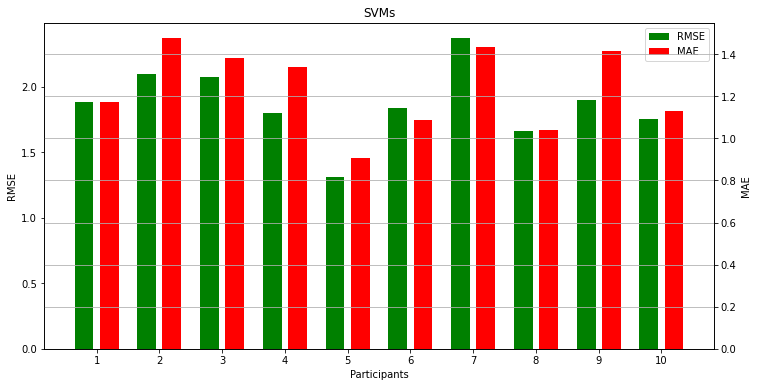

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_svm),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_svm,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('SVMs')
plt.grid(True)
plt.show()

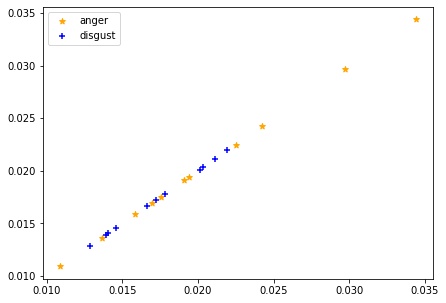

In [ ]:
# PROOF FOR NON-LINEARITY OF DATA
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant0.csv').to_numpy()
x=welch(df, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]

x=np.mean(x,axis=1)

anger=x[[0,9,18,27,40,49,58,67,75,84,93]]
disgust=x[[1,10,19,28,42,51,60,68,71,80,89]]

# PLOT TO SHOW DATA ARE NOT LINEARLY SEPERABLE
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(anger,anger,color=['orange'],label='anger',marker='*')
plt.scatter(disgust,disgust,color='blue',label='disgust',marker='+')
plt.legend()
plt.show()

In [ ]:
# MACHINE LEARNING
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY

# save decoded signals in csv format
rmse_knn=[]
mae_knn=[]
psd_knn=np.zeros([9,95,51])
for participant in range(9):
  df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant'+str(participant+1)+'.csv')
  dec=df.to_numpy()
  psd_knn[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True,nperseg=100, scaling='density', axis=- 1, average='mean')[1]
  X_train, X_test, y_train, y_test = train_test_split(psd_knn[participant], y_new[participant], test_size=0.2, random_state=42)

  # REGRESSION 
  # With k-NNs
  knn=KNeighborsRegressor(n_neighbors=25)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_knn[participant],y_new[participant],cv=5)

  # METRICS FOR k-NN
  MSE_knn=mean_squared_error(y_new[participant],y_pred_knn)
  MAE_knn=mean_absolute_error(y_new[participant],y_pred_knn)
  R2_knn=r2_score(y_new[participant],y_pred_knn)
  print('RMSE for participant {} = {}'.format(participant+1,np.sqrt(MSE_knn)))
  print('MAE for participant {} = {}'.format(participant+1,MAE_knn))
  print('R2 for participant {} = {}'.format(participant+1,R2_knn))
  print('')
  rmse_knn.append(MSE_knn)
  mae_knn.append(MAE_knn)

# FIRST PARTICIPANT
psd_knn_00=np.zeros([94,51])
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant0.csv')
dec_00=df.to_numpy()
psd_knn_00=welch(dec_00, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]

# REGRESSION 
# With k-NNs
knn=KNeighborsRegressor(n_neighbors=71)
regr_knn=MOR.MultiOutputRegressor(knn)
y_pred_knn=cross_val_predict(regr_knn,psd_knn_00,y_new_00,cv=5)

# METRICS FOR k-NN
MSE_knn=mean_squared_error(y_new_00,y_pred_knn)
MAE_knn=mean_absolute_error(y_new_00,y_pred_knn)
R2_knn=r2_score(y_new_00,y_pred_knn)
print('RMSE for participant 0 = {}'.format(np.sqrt(MSE_knn)))
print('MAE for participant 0 = {}'.format(MAE_knn))
print('R2 for participant 0 = {}'.format(R2_knn))
print('')
rmse_knn.insert(0,MSE_knn)
mae_knn.insert(0,MAE_knn)

RMSE for participant 1 = 1.9615275107524226
MAE for participant 1 = 1.6457543859649126
R2 for participant 1 = -0.018648615910929738

RMSE for participant 2 = 1.9614530954407337
MAE for participant 2 = 1.5564912280701755
R2 for participant 2 = -0.030693252314544155

RMSE for participant 3 = 1.6971455912486522
MAE for participant 3 = 1.4405614035087726
R2 for participant 3 = -0.05287337013700336

RMSE for participant 4 = 1.2780753073383702
MAE for participant 4 = 0.9882105263157893
R2 for participant 4 = -0.04979948027596803

RMSE for participant 5 = 1.7238602133258134
MAE for participant 5 = 1.22680701754386
R2 for participant 5 = -0.041772871948007016

RMSE for participant 6 = 2.221278910897954
MAE for participant 6 = 1.7127017543859646
R2 for participant 6 = -0.027521922358988354

RMSE for participant 7 = 1.5915072851220287
MAE for participant 7 = 1.1365614035087717
R2 for participant 7 = -0.025217797152510418

RMSE for participant 8 = 1.8176831214005813
MAE for participant 8 = 1.4630

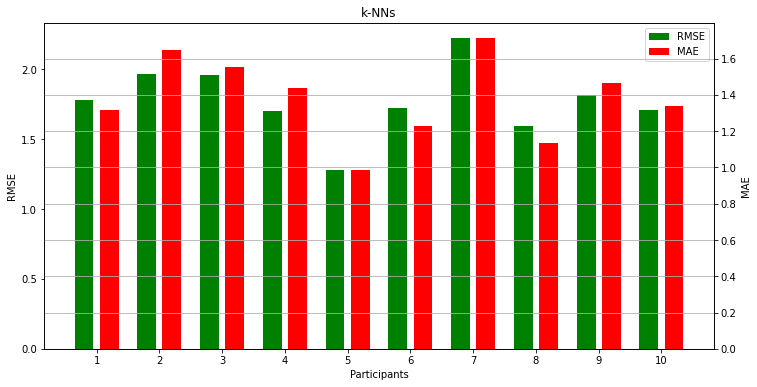

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_knn),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_knn,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('k-NNs')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


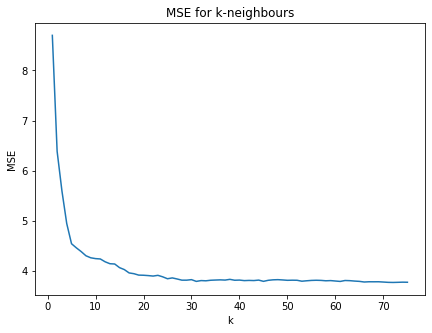


Number of k with lowest MSE equal to 71 and with MSE equal to 3.766774962096601


In [ ]:
# HYPER-PARAMETER TUNING FOR K-NNS
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_knn=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

mse=[]
for k in range(1,76):
  knn=KNeighborsRegressor(n_neighbors=k)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_knn,y_new[1],cv=5)
  MSE_knn=mean_squared_error(y_new[1],y_pred_knn)
  mse.append(MSE_knn)

k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,76),mse)
plt.title('MSE for k-neighbours')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of k with lowest MSE equal to {} and with MSE equal to {}'.format(k[0][0],np.min(mse)))

In [ ]:
psd_rf=np.zeros([9,95,51])

rmse_rf=[]
mae_rf=[]
for participant in range(9):
  df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant'+str(participant+1)+'.csv')
  dec=df.to_numpy()
  psd_rf[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]
  
  # REGRESSION 
  # With RFs
  rf=RandomForestRegressor(n_estimators=55, criterion='squared_error', max_depth=1)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf[participant],y_new[participant],cv=5)

  # METRICS FOR RF
  MSE_rf=mean_squared_error(y_new[participant],y_pred_rf)
  MAE_rf=mean_absolute_error(y_new[participant],y_pred_rf)
  R2_rf=r2_score(y_new[participant],y_pred_rf)
  print('RMSE for participant {} = {}'.format(participant+1,np.sqrt(MSE_rf)))
  print('MAE for participant {} = {}'.format(participant+1,MAE_rf))
  print('R2 for participant {} = {}'.format(participant+1,R2_rf))
  print('')
  rmse_rf.append(MSE_rf)
  mae_rf.append(MAE_rf)

# FIRST PARTICIPANT
psd_rf_00=np.zeros([94,51])
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant0.csv')
dec_00=df.to_numpy()
psd_rf_00=welch(dec_00, fs=128, window='hann', detrend='constant', return_onesided=True, nperseg=100, scaling='density', axis=- 1, average='mean')[1]

# REGRESSION 
# With RFs
rf=RandomForestRegressor(n_estimators=21, criterion='squared_error',max_depth=10)
regr_rf=MOR.MultiOutputRegressor(rf)
y_pred_rf=cross_val_predict(regr_rf,psd_rf_00,y_new_00,cv=5)

# METRICS FOR RF
MSE_rf=mean_squared_error(y_new_00,y_pred_rf)
MAE_rf=mean_absolute_error(y_new_00,y_pred_rf)
R2_rf=r2_score(y_new_00,y_pred_rf)

print('RMSE for participant 0 = {}'.format(np.sqrt(MSE_rf)))
print('MAE for participant 0 = {}'.format(MAE_rf))
print('R2 for participant 0 = {}'.format(R2_rf))
print('')
rmse_rf.insert(0,MSE_rf)
mae_rf.insert(0,MAE_rf)

RMSE for participant 1 = 1.968720123957185
MAE for participant 1 = 1.6520209448118985
R2 for participant 1 = -0.031068492092130695

RMSE for participant 2 = 2.007144547725217
MAE for participant 2 = 1.587787927543271
R2 for participant 2 = -0.08085114130318598

RMSE for participant 3 = 1.7141100261044029
MAE for participant 3 = 1.4271996127323527
R2 for participant 3 = -0.0908148930001232

RMSE for participant 4 = 1.2977546188769782
MAE for participant 4 = 1.0027036870212545
R2 for participant 4 = -0.07022581724731551

RMSE for participant 5 = 1.749209636477179
MAE for participant 5 = 1.2245150673251461
R2 for participant 5 = -0.05299853860821694

RMSE for participant 6 = 2.2168373089205917
MAE for participant 6 = 1.6977496898538422
R2 for participant 6 = -0.021856945981231335

RMSE for participant 7 = 1.5949808638415137
MAE for participant 7 = 1.1754969240865527
R2 for participant 7 = -0.033193933784358386

RMSE for participant 8 = 1.8293252728558886
MAE for participant 8 = 1.46001273

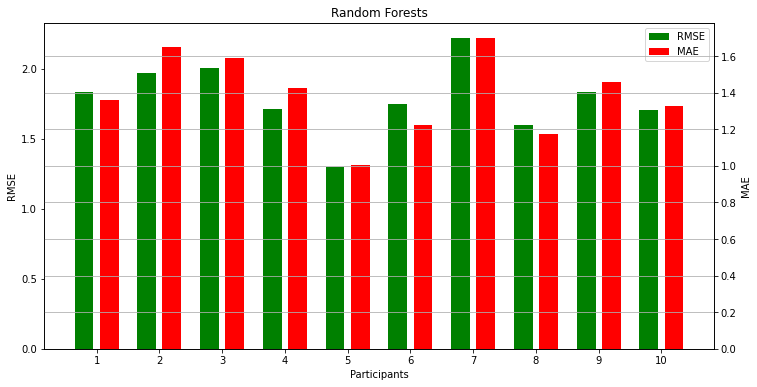

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_rf),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_rf,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('Random Forests')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


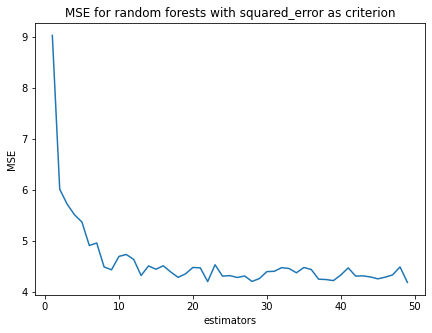


Number of estimators with lowest MSE equal to 48 and with MSE equal to 4.183812300430377


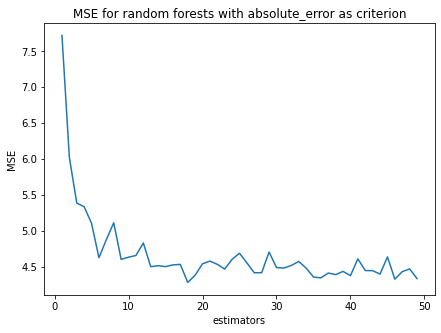


Number of estimators with lowest MSE equal to 17 and with MSE equal to 4.279034004764999


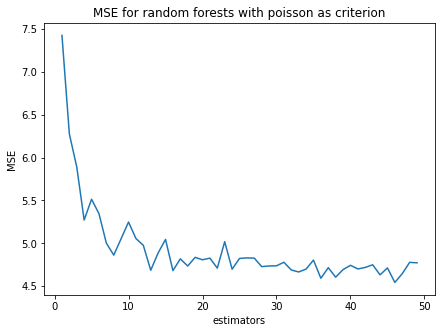


Number of estimators with lowest MSE equal to 45 and with MSE equal to 4.544624083839087


In [ ]:
# HYPER-PARAMETER TUNING FOR RANDOM FORESTS
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]


criteria=['squared_error','absolute_error', 'poisson']

for criterion in criteria:
  mse=[]
  for estimator in range(1,50):
    rf=RandomForestRegressor(n_estimators=estimator, criterion=criterion, max_depth=None)
    regr_rf=MOR.MultiOutputRegressor(rf)
    y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
    MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
    mse.append(MSE_rf)

  _k=np.where(mse==np.min(mse))

  plt.figure(figsize=(7,5))
  plt.plot(range(1,50),mse)
  plt.title('MSE for random forests with {} as criterion'.format(criterion))
  plt.xlabel('estimators')
  plt.ylabel('MSE')
  plt.show()
  print('')
  print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


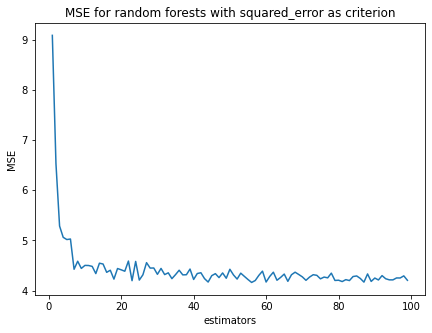


Number of estimators with lowest MSE equal to 55 and with MSE equal to 4.161500850340137


In [ ]:
# TUNING FOR NUMBER OF ESTIMATORS
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

mse=[]
for estimator in range(1,100):
  rf=RandomForestRegressor(n_estimators=estimator, criterion='squared_error', max_depth=None)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
  MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,100),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


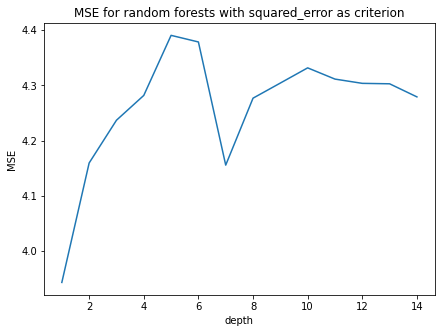


Maximum depth with lowest MSE equal to 0 and with MSE equal to 3.943151633971008


In [ ]:
# TUNING FOR MAX-DEPTH
df=pd.read_csv('/content/drive/My Drive/Dissertation/MYDATA_NEW/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

mse=[]
for depth in range(1,15):
  rf=RandomForestRegressor(n_estimators=55, criterion='squared_error', max_depth=depth)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
  MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,15),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('depth')
plt.ylabel('MSE')
plt.show()
print('')
print('Maximum depth with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))